# Lab 02 — Speed command to encoder counts/sec calibration (Phase 3)

We build a mapping from speed command `v` (GUI units) to the forward encoder rate:
\[
r \triangleq \frac{e_{\mathrm{fwd}}}{T} \quad [\text{counts/s}]
\]
where forward counts are defined from the measured encoder change:
\[
e_{\mathrm{fwd}} = -\Delta e \ge 0
\]
because forward motion produces negative encoder count changes on our robot.

We fit:
1. A **through-origin polynomial** for rate vs speed (nonlinear allowed):
\[
r(v) = a_1 v + a_2 v^2 + a_3 v^3
\]
(we evaluate degree 1,2,3 and select the best by RMSE)

2. A **straight-line through origin** variance model:
\[
\sigma_r^2(v) = k_{sr} v
\]
where \(\sigma_r^2\) is the variance of the rate computed from repeated trials at each speed.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
# -----------------------------
# Raw data: distance is not needed here; only encoder deltas + durations.
# -----------------------------

data = {
    100: {"T": 3.5, "de": [-3606, -3698, -3479, -3794, -3707, -3947, -3910, -3822, -3913, -3960, -3838, -3907, -3772, -3991]},
    60:  {"T": 3.0, "de": [-1440, -1497, -1361, -1485, -1555]},
    80:  {"T": 3.0, "de": [-2759, -2669, -2750, -2734, -2748]},
}

# Flatten into per-trial arrays of (v, r)
v_list, r_list = [], []

for v, d in data.items():
    T = float(d["T"])
    for de in d["de"]:
        e_fwd = -float(de)          # forward counts are positive
        r = e_fwd / T               # counts per second
        v_list.append(float(v))
        r_list.append(float(r))

v_arr = np.array(v_list, dtype=float)
r_arr = np.array(r_list, dtype=float)

print("Total trials:", len(r_arr))
print("Unique speeds:", sorted(set(v_arr)))
print("Rate stats (counts/s): mean=", r_arr.mean(), "std=", r_arr.std(ddof=1))

Total trials: 24
Unique speeds: [np.float64(60.0), np.float64(80.0), np.float64(100.0)]
Rate stats (counts/s): mean= 926.686507936508 std= 242.39488540927488


## Compute per-speed summary statistics
We compute the per-speed mean rate and sample variance of rate.


In [3]:
speeds = sorted(data.keys())
v_pts = np.array(speeds, dtype=float)

mean_r = {}
var_r = {}
n_r = {}

for v in speeds:
    T = float(data[v]["T"])
    e_fwd = -np.array(data[v]["de"], dtype=float)
    r = e_fwd / T
    
    mean_r[v] = float(np.mean(r))
    # sample variance is standard for repeated trials
    var_r[v] = float(np.var(r, ddof=1)) if len(r) > 1 else 0.0
    n_r[v] = int(len(r))

print("Per-speed rate mean (counts/s):", mean_r)
print("Per-speed rate var  ((counts/s)^2):", var_r)
print("Trials per speed:", n_r)

var_pts = np.array([var_r[v] for v in speeds], dtype=float)
mean_pts = np.array([mean_r[v] for v in speeds], dtype=float)

Per-speed rate mean (counts/s): {60: 489.2, 80: 910.6666666666667, 100: 1088.6530612244899}
Per-speed rate var  ((counts/s)^2): {60: 581.4222222222224, 80: 146.72222222222234, 100: 1764.5516932047535}
Trials per speed: {60: 5, 80: 5, 100: 14}


## Fit rate model \( r(v) \) using a through-origin polynomial

We fit:
- degree 1: \(r=a_1 v\)
- degree 2: \(r=a_1 v + a_2 v^2\)
- degree 3: \(r=a_1 v + a_2 v^2 + a_3 v^3\)

All fits are constrained to go through the origin by not including a constant term.
We select the best degree by RMSE over all trials.

In [4]:
def fit_poly_through_origin(v, r, degree):
    # Design matrix: [v, v^2, ..., v^degree]
    X = np.vstack([v**p for p in range(1, degree+1)]).T
    coef, *_ = np.linalg.lstsq(X, r, rcond=None)
    r_hat = X @ coef
    rmse = float(np.sqrt(np.mean((r - r_hat)**2)))
    return coef, rmse

fits = {}
for deg in [1, 2, 3]:
    coef, rmse = fit_poly_through_origin(v_arr, r_arr, deg)
    fits[deg] = (coef, rmse)
    print(f"degree {deg} coef = {coef}, RMSE = {rmse}")

best_deg = min(fits.keys(), key=lambda d: fits[d][1])
best_coef = fits[best_deg][0]
print("\nBest degree =", best_deg, "coef =", best_coef)

def r_from_speed(v):
    """counts/sec from speed command, using best polynomial through origin."""
    v = np.asarray(v, dtype=float)
    out = np.zeros_like(v)
    for i, c in enumerate(best_coef):
        out += c * (v ** (i+1))
    # counts/sec should not be negative for v>=0; clip for safety
    return np.maximum(0.0, out)

degree 1 coef = [10.71126817], RMSE = 82.25472658607099
degree 2 coef = [6.59847881 0.04429875], RMSE = 64.50078333268995
degree 3 coef = [-2.38974830e+01  8.13690476e-01 -4.65850340e-03], RMSE = 32.82005851954943

Best degree = 3 coef = [-2.38974830e+01  8.13690476e-01 -4.65850340e-03]


## Fit variance model \( \sigma_r^2(v)=k_{sr}v \) through the origin

We compute the empirical per-speed variance from repeated trials, then fit a straight line
through the origin:
\[
k_{sr} = \frac{\sum v_i \,\widehat{\sigma_r^2}(v_i)}{\sum v_i^2}.
\]


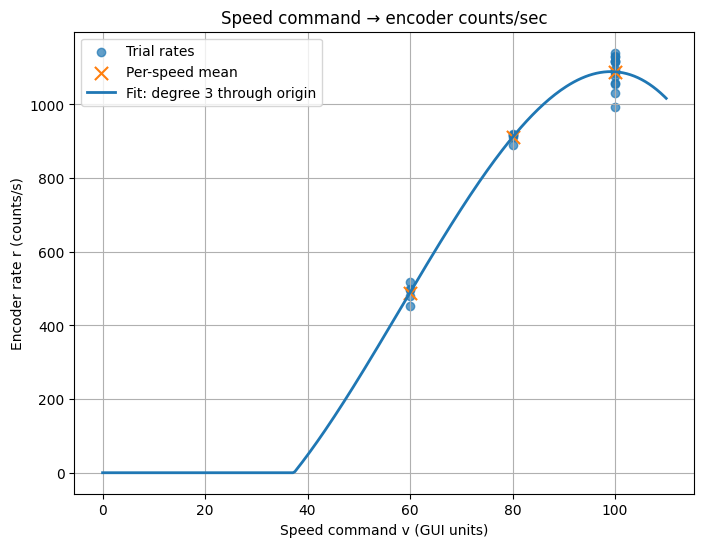

In [5]:
plt.figure(figsize=(8,6))
plt.scatter(v_arr, r_arr, alpha=0.7, label="Trial rates")

# per-speed means
plt.scatter(v_pts, mean_pts, s=90, marker="x", label="Per-speed mean")

vgrid = np.linspace(0, max(speeds)*1.1, 300)
plt.plot(vgrid, r_from_speed(vgrid), linewidth=2, label=f"Fit: degree {best_deg} through origin")

plt.xlabel("Speed command v (GUI units)")
plt.ylabel("Encoder rate r (counts/s)")
plt.title("Speed command → encoder counts/sec")
plt.grid(True)
plt.legend()
plt.show()

In [8]:
k_sr = float((v_pts @ var_pts) / (v_pts @ v_pts))
k_sr = max(0.0, k_sr)

print("k_sr =", k_sr, "((counts/s)^2 per speed_unit)")

def var_r_from_speed(v):
    v = np.asarray(v, dtype=float)
    return k_sr * np.maximum(0.0, v)

k_sr = 11.153914021579324 ((counts/s)^2 per speed_unit)


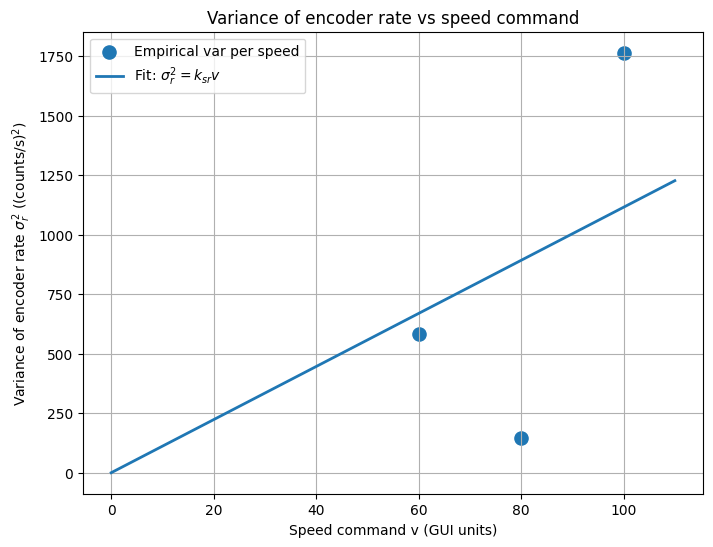

In [9]:
plt.figure(figsize=(8,6))
plt.scatter(v_pts, var_pts, s=90, label="Empirical var per speed")

vgrid = np.linspace(0, max(speeds)*1.1, 300)
plt.plot(vgrid, var_r_from_speed(vgrid), linewidth=2, label=r"Fit: $\sigma_r^2 = k_{sr} v$")

plt.xlabel("Speed command v (GUI units)")
plt.ylabel(r"Variance of encoder rate $\sigma_r^2$ ((counts/s)$^2$)")
plt.title("Variance of encoder rate vs speed command")
plt.grid(True)
plt.legend()
plt.show()

In [10]:
print("---- paste-ready code ----")
print("# Speed -> encoder counts/sec calibration")
print(f"# Best degree = {best_deg}")
for i, c in enumerate(best_coef):
    print(f"A{i+1} = {c:.18e}")

print("\nSIGMA_R2_SLOPE = {:.18e}  # (counts/s)^2 per speed unit".format(k_sr))

print("\ndef counts_per_sec_from_speed(v_cmd):")
print("    v = float(v_cmd)")
print("    r = 0.0")
for i in range(best_deg):
    p = i+1
    print(f"    r += A{p} * (v ** {p})")
print("    return max(0.0, r)")

print("\ndef var_counts_per_sec_from_speed(v_cmd):")
print("    v = float(v_cmd)")
print("    return max(0.0, SIGMA_R2_SLOPE * v)")


---- paste-ready code ----
# Speed -> encoder counts/sec calibration
# Best degree = 3
A1 = -2.389748299319578351e+01
A2 = 8.136904761904759642e-01
A3 = -4.658503401360606679e-03

SIGMA_R2_SLOPE = 1.115391402157932355e+01  # (counts/s)^2 per speed unit

def counts_per_sec_from_speed(v_cmd):
    v = float(v_cmd)
    r = 0.0
    r += A1 * (v ** 1)
    r += A2 * (v ** 2)
    r += A3 * (v ** 3)
    return max(0.0, r)

def var_counts_per_sec_from_speed(v_cmd):
    v = float(v_cmd)
    return max(0.0, SIGMA_R2_SLOPE * v)
